## Forecasting Madrid's Monthly Average Temperature Using SARIMA


Here’s an introduction for your SARIMA time series analysis of Madrid's monthly average temperature:  

---

**Forecasting Madrid's Monthly Average Temperature Using SARIMA**  

Time series forecasting is an essential tool for understanding climate trends and making informed decisions based on historical weather data. In this project, we will analyze and forecast the monthly average temperature in Madrid using the **Seasonal AutoRegressive Integrated Moving Average (SARIMA)** model.  

The dataset, obtained from Kaggle, contains daily weather observations in Madrid, Spain, covering several years. To ensure consistency and reduce noise, we will aggregate the data into **monthly averages** before applying our time series model.  

Our approach will involve:  
1. **Exploratory Data Analysis (EDA):** Understanding trends, seasonality, and stationarity in the dataset.  
2. **Preprocessing:** Handling missing values, aggregating data into monthly averages, and performing transformations if necessary.  
3. **Model Selection:** Identifying the optimal SARIMA parameters using **Autocorrelation (ACF)** and **Partial Autocorrelation (PACF)** plots.  
4. **Model Training & Evaluation:** Training the SARIMA model, validating its performance, and tuning hyperparameters.  
5. **Forecasting:** Generating predictions for future monthly temperatures and visualizing the results.  

By leveraging SARIMA, we aim to capture both the trend and seasonal patterns of Madrid’s temperature fluctuations, providing accurate forecasts for the coming months. This analysis could serve as a foundation for more advanced climate modeling and decision-making processes related to weather predictions.


https://www.kaggle.com/datasets/mahdiehhajian/madrid-daily-weather

# Data Collection and Preprocessing

In [54]:
# RUN THIS CELL
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import itertools
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

import seaborn as sns

# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX


from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima                              # for determining ARIMA orders

# Load specific evaluation tools
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")





In [55]:
import kagglehub


path = kagglehub.dataset_download("mahdiehhajian/madrid-daily-weather")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\caioe\.cache\kagglehub\datasets\mahdiehhajian\madrid-daily-weather\versions\1


In [56]:
import os

# Files in the path

print("Files in the path:")
print(os.listdir(path))


Files in the path:
['Madrid Daily Weather 1997-2015.csv']


In [57]:

csv_path = f"{path}\\Madrid Daily Weather 1997-2015.csv"  


df = pd.read_csv(csv_path, index_col='CET', parse_dates=True) 




In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6812 entries, 1997-01-01 to 2015-12-31
Data columns (total 22 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Max TemperatureC             6810 non-null   float64
 1   Mean TemperatureC            6809 non-null   float64
 2   Min TemperatureC             6810 non-null   float64
 3   Dew PointC                   6810 non-null   float64
 4   MeanDew PointC               6810 non-null   float64
 5   Min DewpointC                6810 non-null   float64
 6   Max Humidity                 6810 non-null   float64
 7    Mean Humidity               6810 non-null   float64
 8    Min Humidity                6810 non-null   float64
 9    Max Sea Level PressurehPa   6812 non-null   int64  
 10   Mean Sea Level PressurehPa  6812 non-null   int64  
 11   Min Sea Level PressurehPa   6812 non-null   int64  
 12   Max VisibilityKm            5872 non-null   float64
 13  

In [59]:
df= df['Mean TemperatureC']


In [60]:
df = df.resample('M').mean()

In [61]:
df = pd.DataFrame(df)


In [62]:
df.isna().sum()




Mean TemperatureC    2
dtype: int64

In [63]:
df['Month'] = df.index.month

# Calculando a média por mês
monthly_mean = df.groupby('Month')['Mean TemperatureC'].transform('mean')

# Preenchendo valores vazios com a média do mês
df['Mean TemperatureC'] = df['Mean TemperatureC'].fillna(monthly_mean)

# Removendo a coluna auxiliar (opcional)
df = df.drop(columns=['Month'])

# "Time Series Visualization"

In [64]:
import seaborn as sns

In [65]:
import pandas as pd
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# Supondo que 'df' já esteja definido e possua a coluna 'Mean TemperatureC'
mean = df['Mean TemperatureC'].mean()
std = df['Mean TemperatureC'].std()
rolling_mean = df['Mean TemperatureC'].rolling(12).mean()
rolling_std = df['Mean TemperatureC'].rolling(12).std()

fig = make_subplots(rows=1, cols=1)
fig.add_trace(go.Scatter(x=df.index, y=df['Mean TemperatureC'], mode='lines', name="Mean Temperature", line=dict(color='black')))
fig.add_trace(go.Scatter(x=df.index, y=[mean] * len(df), mode='lines', name=f"General Avg ({mean:.2f})", line=dict(dash='dash', color='blue')))
fig.add_trace(go.Scatter(x=df.index, y=rolling_mean, mode='lines', name="Moving Avg", line=dict(color='purple')))
fig.add_trace(go.Scatter(x=df.index, y=[mean + std] * len(df), mode='lines', name="Std Dev.", line=dict(color='orange', dash='dot')))
fig.add_trace(go.Scatter(x=df.index, y=[mean - std] * len(df), mode='lines', name="Std Dev.", line=dict(color='orange', dash='dot')))
fig.add_trace(go.Scatter(x=df.index, y=rolling_mean + rolling_std, mode='lines', name="Mov Dev.", line=dict(color='green', dash='dot')))
fig.add_trace(go.Scatter(x=df.index, y=rolling_mean - rolling_std, mode='lines', name="Mov Dev.", line=dict(color='green', dash='dot')))

fig.update_layout(title="Mean Temperature", xaxis_title="Date", yaxis_title="Temperature [ºC]", legend_title="Legend")
fig.show()


# Seasonal Decomposition

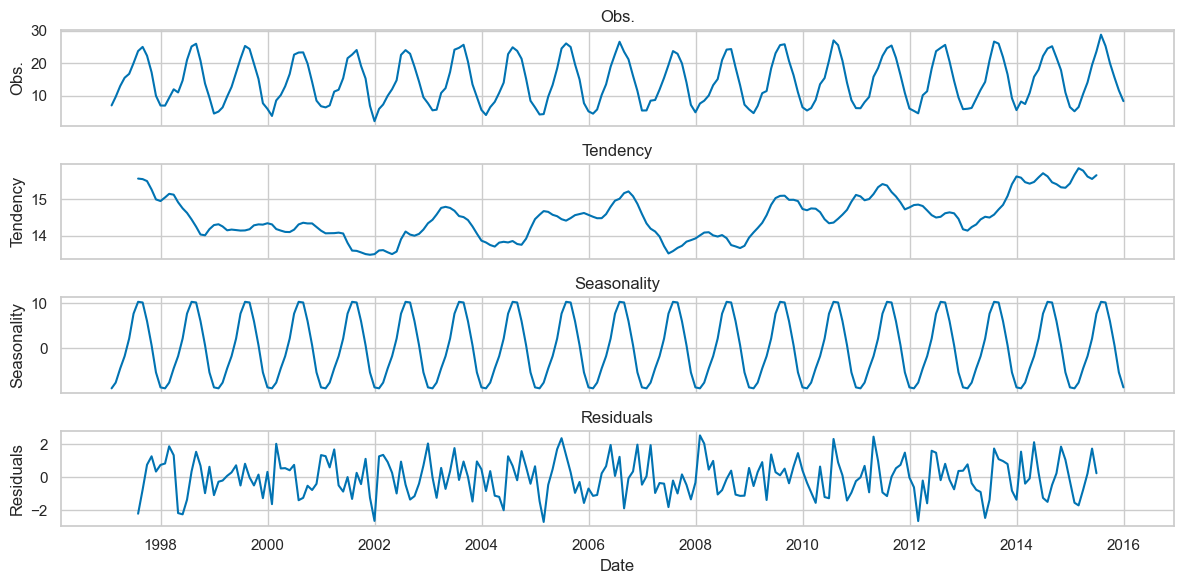

In [66]:

import pandas as pd



result = seasonal_decompose(df['Mean TemperatureC'], model='additive', period=12)

decomp_df = pd.DataFrame({
    "Obs.": result.observed,
    "Tendency": result.trend,
    "Seasonality": result.seasonal,
    "Residuals": result.resid
}, index=df.index)


sns.set(style="whitegrid", palette="colorblind")


fig, axes = plt.subplots(4, 1, figsize=(12, 6), sharex=True)

for ax, col in zip(axes, decomp_df.columns):
    sns.lineplot(data=decomp_df, x=decomp_df.index, y=decomp_df[col], ax=ax)
    ax.set_title(col)

plt.xlabel("Date")
plt.tight_layout()
plt.show()



Time Series above seems to have a pattern, there's a clear tendency and seasonality. So, we need to analyze those features

# Stationarity Analysis

Stationarity analysis is a crucial step in time series modeling, as many forecasting techniques require the series to be stationary. A time series is considered stationary when its statistical properties, such as mean and variance, do not change over time. To check for stationarity, the Augmented Dickey-Fuller (ADF) test can be performed, which tests for the presence of a unit root in the time series. If the series passes the ADF test, it indicates that the series is stationary, while a negative result suggests that the series is non-stationary and may require transformations, such as differencing, to become stationary.

In [67]:
import pandas as pd

def auto_differencing_df(series, n):
   
    differenced_series = pd.DataFrame(index=series.index)

   
    differenced_series['Original'] = series

    
    for i in range(1, n + 1):
        differenced_series[f"Differenced_{i}"] = series.diff(i)

    
    differenced_series = differenced_series.dropna()

    return differenced_series




In [68]:
# Definir o número de diferenciações desejado (exemplo: 3)
n = 3

# Aplicar a diferenciação
differenced_df = auto_differencing_df(df["Mean TemperatureC"], n)

# Visualizar o DataFrame com as diferenciações
differenced_df.head()

,Original,Differenced_1,Differenced_2,Differenced_3
CET,,,,
1997-04-30,15.500000,2.532258,5.892857,8.532258
1997-05-31,16.709677,1.209677,3.741935,7.102535
1997-06-30,20.033333,3.323656,4.533333,7.065591
1997-07-31,23.741935,3.708602,7.032258,8.241935
1997-08-31,25.032258,1.290323,4.998925,8.322581


adf

In [69]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

def adf_test_summary(series, max_diff=5):
    results = []

    for d in range(0, max_diff + 1):
        # Diferenciação da série
        if d == 0:
            series_diff = series  # Série original
            diff_label = "Original"
        else:
            series_diff = series.diff(d).dropna()  # Aplica diferenciação e remove NaN
            diff_label = f"Differentiation {d}"
        
        # Executar o teste ADF
        adf_result = adfuller(series_diff, autolag="AIC")
        
        # Coletar resultados relevantes
        result_dict = {
            "Differentiation": diff_label,
            "ADF Statistic": adf_result[0],
            "p-value": adf_result[1],
            "Lags Used": adf_result[2],
            "Number of Observations": adf_result[3],
            "Critical Value (1%)": adf_result[4]["1%"],
            "Critical Value (5%)": adf_result[4]["5%"],
            "Critical Value (10%)": adf_result[4]["10%"],
            "Stationary?": "Yes" if adf_result[1] < 0.05 else "No"
        }
        
        results.append(result_dict)
        
        # Se a série já for estacionária, interrompe o loop
        if adf_result[1] < 0.05:
            break

    # Converter para DataFrame
    results_df = pd.DataFrame(results)
    return results_df


In [70]:
adf_results = adf_test_summary(df["Mean TemperatureC"], max_diff=3)


adf_results

,Differentiation,ADF Statistic,p-value,Lags Used,Number of Observations,Critical Value (1%),Critical Value (5%),Critical Value (10%),Stationary?
0,Original,-2.538320,1.064269e-01,13,214,-3.461282,-2.875143,-2.574020,No
1,Differentiation 1,-11.104476,3.792990e-20,11,215,-3.461136,-2.875079,-2.573986,Yes


I was able to stationarize the series with just one differentiation, as confirmed by the ADF test. However, the series remains seasonal, as it can be described in graphics below:

In [71]:



# Supondo que 'differenced_df' já esteja definido e possua a coluna 'Differenced_1'
mean = differenced_df['Differenced_1'].mean()
std = differenced_df['Differenced_1'].std()

fig = make_subplots(rows=1, cols=1)
fig.add_trace(go.Scatter(x=differenced_df.index, y=differenced_df['Differenced_1'], mode='lines', name="First Differenciation", line=dict(color='black')))
fig.add_trace(go.Scatter(x=differenced_df.index, y=[mean] * len(differenced_df), mode='lines', name=f"General Avg ({mean:.2f})", line=dict(dash='dash', color='blue')))
fig.add_trace(go.Scatter(x=differenced_df.index, y=[mean + std] * len(differenced_df), mode='lines', name="Std Dev", line=dict(color='orange', dash='dot')))
fig.add_trace(go.Scatter(x=differenced_df.index, y=[mean - std] * len(differenced_df), mode='lines', name="Std Dev", line=dict(color='orange', dash='dot')))

fig.update_layout(title="First Differenciation", xaxis_title="Date", yaxis_title="Temperature [ºC]", legend_title="Legenda")
fig.show()


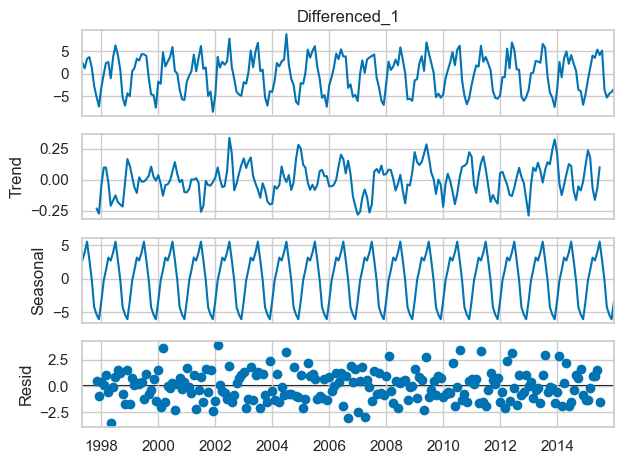

In [72]:
result = seasonal_decompose(differenced_df['Differenced_1'], model='additive', period=12)

result.plot()

plt.show()

# Seasonality Analysis

In [73]:
differenced_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 225 entries, 1997-04-30 to 2015-12-31
Freq: ME
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Original       225 non-null    float64
 1   Differenced_1  225 non-null    float64
 2   Differenced_2  225 non-null    float64
 3   Differenced_3  225 non-null    float64
dtypes: float64(4)
memory usage: 8.8 KB


# Subtracting the Seasonal Component  

I used a 12-shift difference because the data exhibits yearly seasonality, meaning that patterns repeat every 12 months. By subtracting the value from 12 months ago, we remove the seasonal effect and focus on the underlying trend and irregular variations.

In [74]:


df_seasonal = differenced_df.copy()

df_seasonal["diff_season"] = differenced_df["Differenced_1"].diff(12)
df_seasonal = df_seasonal.dropna(subset=['diff_season'])







In [75]:

# Supondo que 'differenced_df' já esteja definido e possua a coluna 'Differenced_1'
mean = df_seasonal["diff_season"].mean()
std = df_seasonal["diff_season"].std()

fig = make_subplots(rows=1, cols=1)
fig.add_trace(go.Scatter(x=df_seasonal.index, y=df_seasonal['diff_season'], mode='lines', name="Valores reais", line=dict(color='black')))
fig.add_trace(go.Scatter(x=df_seasonal.index, y=[mean] * len(df_seasonal), mode='lines', name=f"Média geral ({mean:.2f})", line=dict(dash='dash', color='blue')))
fig.add_trace(go.Scatter(x=df_seasonal.index, y=[mean + std] * len(df_seasonal), mode='lines', name="Desvio padrão (acima)", line=dict(color='orange', dash='dot')))
fig.add_trace(go.Scatter(x=df_seasonal.index, y=[mean - std] * len(df_seasonal), mode='lines', name="Desvio padrão (abaixo)", line=dict(color='orange', dash='dot')))

fig.update_layout(title="Valores, Médias e Desvios Padrão", xaxis_title="Index", yaxis_title="Temperatura", legend_title="Legenda")
fig.show()

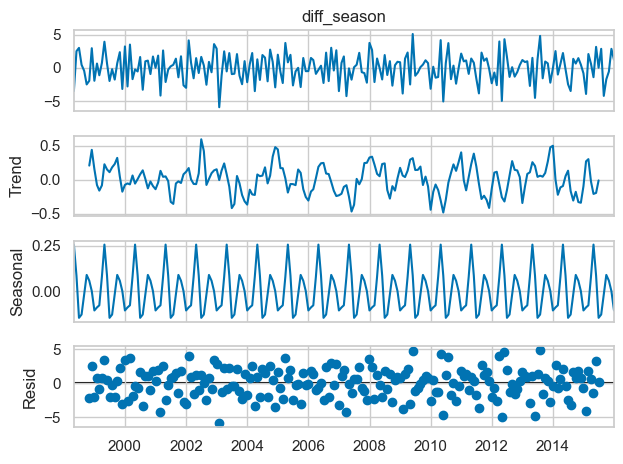

In [76]:
result = seasonal_decompose(df_seasonal['diff_season'], model='additive', period=12)

result.plot()

plt.show()

It looks like I managed to remove the seasonality with a 12-shift difference.

# Pattern Identification

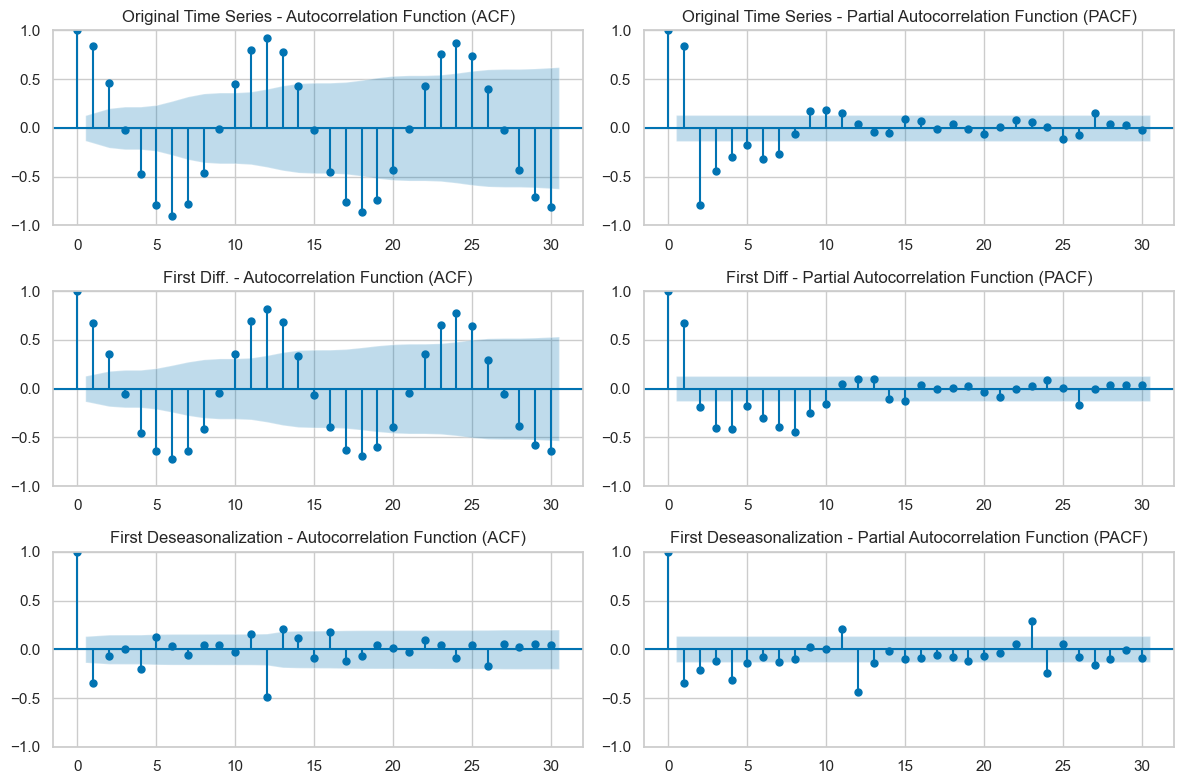

In [77]:

fig, axes = plt.subplots(3, 2, figsize=(12, 8))


plot_acf(df['Mean TemperatureC'], lags=30, ax=axes[0, 0])
axes[0, 0].set_title("Original Time Series - Autocorrelation Function (ACF)")

plot_pacf(df['Mean TemperatureC'], lags=30, ax=axes[0, 1])
axes[0, 1].set_title("Original Time Series - Partial Autocorrelation Function (PACF)")


plot_acf(differenced_df['Differenced_1'], lags=30, ax=axes[1, 0])
axes[1, 0].set_title("First Diff. - Autocorrelation Function (ACF)")


plot_pacf(differenced_df['Differenced_1'], lags=30, ax=axes[1, 1])         
axes[1, 1].set_title("First Diff - Partial Autocorrelation Function (PACF)")

plot_acf(df_seasonal['diff_season'], lags=30, ax=axes[2, 0])
axes[2, 0].set_title("First Deseasonalization - Autocorrelation Function (ACF)")


plot_pacf(df_seasonal['diff_season'], lags=30, ax=axes[2, 1])  
axes[2, 1].set_title("First Deseasonalization - Partial Autocorrelation Function (PACF)")

plt.tight_layout()
plt.show()





Ok, by the chart, I would say, the best chooice would be for arima could be p = 7, q = 2 and d = 1.  P≥1 if the ACF is positive at lag S, else P=0; Q≥1 if the ACF is negative at lag S, else Q=0; Rule of thumb: P+Q≤2. So, I will try manually SARIMA (7, 1, 2) (1, 1, 0, 12)

In [78]:
model1 = SARIMAX(df, order=(7, 1, 2), seasonal_order=(1, 1, 0, 12))
model1_fit = model1.fit(disp=False)
model1_fit.aic

805.807395678054

So, next step, let's try a plenty of values which are posible, according to PACF and ACF, p = [0,7], d = 1, q = [0,2]. P and Q, I inffer to P = [0,2], Q = [0,2], D =1.

In [80]:
series = df['Mean TemperatureC']

p_values = list(range(8))  
d_values = [1]
q_values = list(range(3))  


P_values = list(range(3))  
D_values = [1] 
Q_values = list(range(3))  
seasonal_period = 12

parameters = list(itertools.product(p_values, d_values, q_values, P_values, D_values, Q_values))


results = []


for (p, d, q, P, D, Q) in parameters:
    try:
        
        model = SARIMAX(series, order=(p, d, q), seasonal_order=(P, D, Q, seasonal_period))
        model_fit = model.fit(disp=False)
        
        
        results.append({
            "p": p,
            "d": d,
            "q": q,
            "P": P,
            "D": D,
            "Q": Q,
            "AIC": model_fit.aic
        })
    except Exception as e:
        # 
        print(f"Error (p={p}, d={d}, q={q}, P={P}, D={D}, Q={Q}): {e}")


results_df = pd.DataFrame(results)


results_df = results_df.sort_values(by="AIC").reset_index(drop=True)


results_df.head(5)




,p,d,q,P,D,Q,AIC
0,1,1,1,2,1,2,742.189781
1,1,1,1,2,1,1,742.193141
2,4,1,1,2,1,1,742.562718
3,4,1,1,2,1,2,742.911663
4,5,1,1,2,1,1,742.973293


According to the combination that I posted in code above, the best fit would be SARIMA (1, 1,1) (2,1,2,12)

In [81]:
model2 = SARIMAX(df, order=(1, 1, 1), seasonal_order=(2, 1, 2, 12))
model2_fit = model2.fit(disp=False)
model2_fit.aic

742.189781241821

In [82]:


model = pm.auto_arima(df['Mean TemperatureC'], seasonal=True, m=12)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  228
Model:             SARIMAX(1, 0, 0)x(1, 0, [1, 2], 12)   Log Likelihood                -402.844
Date:                                 Fri, 31 Jan 2025   AIC                            817.688
Time:                                         16:18:31   BIC                            838.264
Sample:                                     01-31-1997   HQIC                           825.990
                                          - 12-31-2015                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0078      0.008      0.936      0.349      -0.008       0.024
ar.L1          0.4744      0.066      7.140      0.000       0.344       0.605
ar.S.L12       0.9990      0.001    931.723      0.000       0.997       1.001
ma.S.L12      -0.9634      0.082    -11.778      0.000      -1.124      -0.803
ma.S.L24       0.1186      0.073      1.632      0.103      -0.024       0.261
sigma2         1.6336      0.174      9.385      0.000       1.292       1.975
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 1.87
Prob(Q):                              0.90   Prob(JB):                         0.39
Heteroskedasticity (H):               1.02   Skew:                             0.10
Prob(H) (two-sided):                  0.93   Kurtosis:                         2.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

According to auto_arima -> SARIMA (1, 0, 0)x(1, 0, [1, 2], 12), but I will choose (1, 0, 0)(1,0,1,12)

In [83]:
model3 = SARIMAX(df, order=(1, 0, 0), seasonal_order=(1, 0, 1, 12))
model3_fit = model3.fit(disp=False)
model3_fit.aic

832.242963200419

According to AIC Scores, the best order would be: model2 > model1 > model3

# Data Splitting  
# Model Selection

In [91]:
limit = int((len(df)*0.80))
print(limit)

182


In [92]:
train = df.iloc[0:limit]
test = df.iloc[limit:len(df)]

# Sarima based on train-test-split

In [93]:
model1 = SARIMAX(train['Mean TemperatureC'], order=(7, 1, 2), seasonal_order=(1, 1, 0, 12))
model1_fit = model1.fit(disp=False)

model2 = SARIMAX(train['Mean TemperatureC'], order=(1, 1, 1), seasonal_order=(2, 1, 2, 12))
model2_fit = model2.fit(disp=False)

model3 = SARIMAX(train['Mean TemperatureC'], order=(1, 0, 0), seasonal_order=(1, 0, 2, 12))
model3_fit = model3.fit(disp=False)


In [94]:
forecast_model1 = model1_fit.forecast(steps=len(test))
forecast_model2 = model2_fit.forecast(steps=len(test))
forecast_model3 = model3_fit.forecast(steps=len(test))

In [96]:
train = df.iloc[0:limit+1]


# Graph of Training, Testing, and Forecasts

In [99]:

fig = make_subplots(rows=1, cols=1)


fig.add_trace(go.Scatter(x=train.tail(72).index, y=train['Mean TemperatureC'].tail(72), 
                         mode='lines', name='Train', 
                         line=dict(color='#E69F00')))  


fig.add_trace(go.Scatter(x=test.index, y=test['Mean TemperatureC'], 
                         mode='lines', name='Test', 
                         line=dict(color='#999999')))  


fig.add_trace(go.Scatter(x=test.index, y=forecast_model1, 
                         mode='lines', name='Model 1', 
                         line=dict(color='#56B4E9', dash='dash')))  

fig.add_trace(go.Scatter(x=test.index, y=forecast_model2, 
                         mode='lines', name='Model 2', 
                         line=dict(color='#009E73', dash='dash')))  

fig.add_trace(go.Scatter(x=test.index, y=forecast_model3, 
                         mode='lines', name='Model 3', 
                         line=dict(color='#F0E442', dash='dash')))  


fig.update_layout(
    xaxis_title="Data",
    yaxis_title="Mean temperature (°C)",
    title_text="Training, Testing, and Forecasts",
    legend_title="Legend",
    hovermode="x unified",
    template="plotly_white"  )


fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='LightGrey')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='LightGrey')

fig.show();




Accuracy of models

In [39]:
for i, forecast in enumerate([forecast_model1, forecast_model2, forecast_model3]):  # Adicionei 'forecast_sarima' novamente para completar 4 iterações, ajuste conforme necessário
    # Calcular o MAE
    mae = mean_absolute_error(test['Mean TemperatureC'], forecast)
    print(f'MAE Model {i+1}: {mae:.2f}')

    # Calcular o RMSE
    rmse = np.sqrt(mean_squared_error(test['Mean TemperatureC'], forecast))
    print(f'RMSE Model {i+1}: {rmse:.2f}')

    # Calcular o MAPE
    mape = mean_absolute_percentage_error(test['Mean TemperatureC'], forecast) * 100
    print(f'MAPE Model {i+1}: {mape:.2f}%')
    
    print()


MAE Model 1: 1.23
RMSE Model 1: 1.56
MAPE Model 1: 9.47%

MAE Model 2: 1.04
RMSE Model 2: 1.31
MAPE Model 2: 7.77%

MAE Model 3: 1.23
RMSE Model 3: 1.53
MAPE Model 3: 8.85%



After a test based on previous data, the model 2, based on SARIMA order=(1, 1, 1), seasonal_order=(2, 1, 2, 12) has the best fit posible.

# Forecast for 60 months

In [112]:



model = SARIMAX(df['Mean TemperatureC'], order=(1, 1, 1), seasonal_order=(2, 1, 2, 12))
results = model.fit()


forecast = results.get_forecast(steps=60)
forecast_values = forecast.predicted_mean
conf_int = forecast.conf_int()  


forecast_index = pd.date_range(start=df.index[-1] + pd.DateOffset(months=1), periods=60, freq='M')


fig = go.Figure()


fig.add_trace(go.Scatter(x=df.index, y=df['Mean TemperatureC'], mode='lines', name='Real Data', line=dict(color='blue')))

fig.add_trace(go.Scatter(x=forecast_index, y=forecast_values, mode='lines', name='Prediction SARIMA', line=dict(color='red', dash='dash')))


fig.add_trace(go.Scatter(
    x=np.concatenate([forecast_index, forecast_index[::-1]]),  
    y=np.concatenate([conf_int.iloc[:, 0], conf_int.iloc[:, 1][::-1]]),  #
    fill='toself',  
    fillcolor='rgba(255, 0, 0, 0.2)',  
    line=dict(color='rgba(255,255,255,0)'), 
    name='Confidence Interval'
))

# Configurar o layout
fig.update_layout(
    xaxis_title="Data",
    yaxis_title="Mean temperature (°C)",
    title_text="Real data and Forecasts",
    legend_title="Legend",
    hovermode="x unified",
    template="plotly_white"  )

# Mostrar o gráfico
fig.show()
